In [219]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import style 
# style.use('seaborn-colorblind')
sns.set(style='white')

In [220]:
from util import cleanAxes

In [221]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [241]:
from statannotations.Annotator import Annotator

- https://github.com/trevismd/statannotations 


## CRISPRi-screen
<!-- Aim: analyzing differential phenotype of CRISPRi-screen data

Tool: [ScreenProcessing](https://github.com/mhorlbeck/ScreenProcessing)

#### Result:
`CRISPRi-screen/hl60_exp1/DAC_processing_output_genetable_collapsed.txt`
<!--`CRISPRi-screen/hl60_exp2/DAC_processing_output_genetable_collapsed.txt`-->

<!-- > __Note__: all 5 gRNAs considered here.  
-->

#### `DESeq2` normalization 
- https://physiology.med.cornell.edu/faculty/skrabanek/lab/angsd/lecture_notes/08_practical.pdf

In [2]:
library(DESeq2)
library(dplyr)

In [3]:
data = read.table(
    'CRISPRi-screen/hl60_exp1/DAC_mergedcountstable.txt',
    sep='\t',header=TRUE,row.names=1)[-c(1,2),]

data <- mutate_all(data, function(x) as.numeric(as.character(x)))

meta = data.frame(
    sampletype=c(rep('T0',2),rep('treated',2),rep('untreated',2)),
    row.names=colnames(data)
)

In [4]:
dds <- DESeqDataSetFromMatrix(countData = data, colData = meta, design = ~ sampletype)
dds <- estimateSizeFactors(dds)
normalized_counts <- counts(dds, normalized=TRUE)
# DESeq.rlog <- rlog(dds, blind = TRUE)
# rlog.norm.counts <- assay(DESeq.rlog)

write.table(
    normalized_counts, 
    # rlog.norm.counts,
    file="CRISPRi-screen/hl60_exp1/DAC_mergedcountstable_normalized_counts.txt", sep="\t", quote=F
)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


#### Barplot
<!-- 
> Hani - Feb 2022
> - try Welch’s t-test
> - can you show non-targeting guides as well? -->

In [749]:
# Ci_counts0 = pd.read_csv('CRISPRi-screen/hl60_exp1/DAC_mergedcountstable.txt',sep='\t',index_col=0).iloc[2:,]
# Ci_counts0.index = Ci_counts0.index.str.split('_').str[0]
# Ci_counts0.index.name = None
# Ci_counts0 = Ci_counts0.astype(int)
# Ci_counts0 = Ci_counts0[Ci_counts0.sum(axis=1) > 5]

In [750]:
Ci_counts = pd.read_csv('CRISPRi-screen/hl60_exp1/DAC_mergedcountstable_normalized_counts.txt',sep='\t')
Ci_counts.describe().iloc[:3,]

,T0,T0.1,treated,treated.1,untreated,untreated.1
count,104535.00000,104535.00000,104535.000000,104535.000000,104535.000000,104535.000000
mean,545.70697,545.70697,727.478423,727.544124,590.554094,588.936462
std,345.09397,345.09397,2496.508008,2549.954165,478.568782,476.587327


In [751]:
Ci_counts.index = Ci_counts.index.str.split('_').str[0]
Ci_counts.index.name = None
Ci_counts = Ci_counts[Ci_counts.sum(axis=1) > 5]

In [752]:
# Ci_counts[Ci_counts.index != 'non-targeting'].describe().iloc[:3,]
# Ci_counts[Ci_counts.index == 'non-targeting'].describe().iloc[:3,]

In [772]:
def plot_Ci_counts(counts,sgrna,top_n=3, ax=None,ylim=None,T0=True,annotate=True):
    
    df = counts[counts.index == sgrna].T
    if top_n:
        # select top n sgRNAs
        df = pd.DataFrame(
            [list(df.iloc[row,:].nlargest(top_n)) for row,_ in enumerate(df.index)],
            index=[row_id for _,row_id in enumerate(df.index)],
            columns=[sgrna for i in range(top_n)]
        )
        
    df['treatment'] = ["T0","T0","Decitabine","Decitabine","DMSO","DMSO"]
    # df_column_uniquify
    df_columns = df.columns
    new_columns = []
    for counter,item in enumerate(df_columns):
        if sgrna in item:
            newitem = "{}_gRNA{}".format(item, counter + 1)
        else:
            newitem = item
        new_columns.append(newitem)
    df.columns = new_columns
    
    dd=pd.melt(
        df,
        id_vars='treatment',value_vars=[col for col in df.columns if sgrna in col],var_name='columns'
    )
    data_title = "gRNA count" # Normalized
    dd = dd.rename({'value':data_title},axis=1)
    dd[data_title] = dd[data_title].astype(int)
    my_pal = {"Decitabine": "c", "DMSO": "lightgray", 'T0':'azure'}
    
    if not T0:
        dd = dd[dd.treatment != 'T0'].sort_values(by='treatment', axis=0, ascending=True)
    if ax:
        cleanAxes(ax)
        p = sns.boxplot(x='treatment',y=data_title,data=dd,hue='treatment',palette=my_pal,ax=ax,linewidth=1,showfliers=False)
        
        pairs=[("Decitabine","DMSO")]

        if annotate:
            annotator = Annotator(ax, pairs, x='treatment',y=data_title,data=dd)
            # Welch’s t-test
            annotator.configure(
                test='t-test_welch', text_format='simple', loc='outside',
                show_test_name=False,verbose=False,fontsize=9,line_width=1#,color='blue'
            )
            annotator.apply_and_annotate()
            
        ax.set_title(sgrna,y=1.1,fontsize=11)
        ax.set_xlabel(None)
        ax.set_ylim(top=ylim)
        ax.set_yscale('log')

        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
            
        # return p
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=8)

    else: 
        return dd

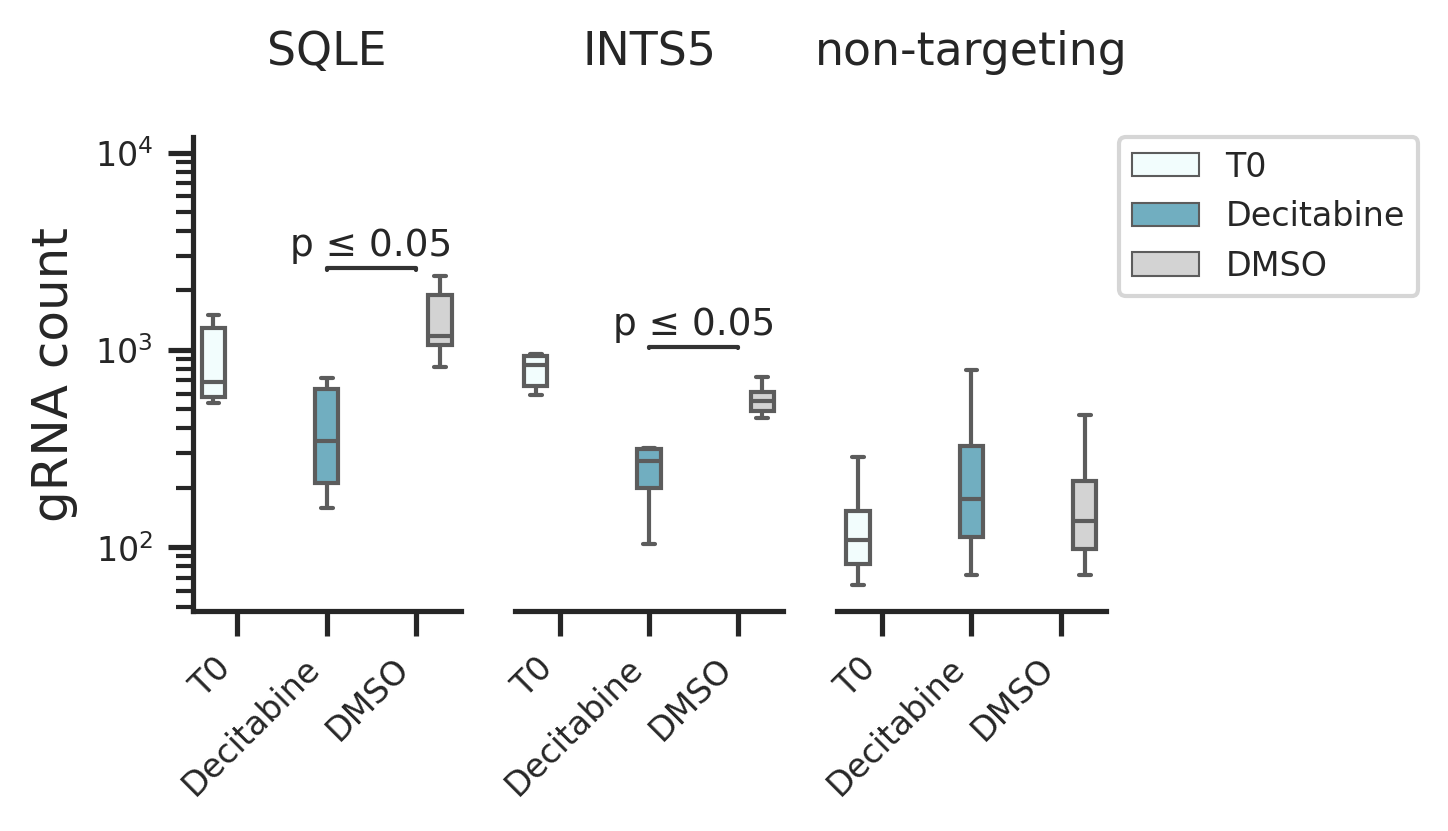

In [773]:
f, axes = plt.subplots(1, 3,figsize=(5,3),dpi=300)
leg = plt.legend()
ylim=1.2*10**4

plot_Ci_counts(Ci_counts,sgrna = 'SQLE',ax=axes[0],T0=True,ylim=ylim)
plot_Ci_counts(Ci_counts,sgrna = 'INTS5',ax=axes[1],T0=True,ylim=ylim)
plot_Ci_counts(Ci_counts,sgrna = 'non-targeting',top_n=800,ax=axes[2],T0=True,ylim=ylim,annotate=False)

for ax in axes:
    ax.get_legend().remove()
    
cleanAxes(axes[1],left=False)
cleanAxes(axes[2],left=False)
axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
axes[1].tick_params(axis='y',label1On=False)
axes[2].tick_params(axis='y',label1On=False)
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 8})

f.tight_layout()
f.savefig('Target-genes/Ci_counts.pdf')

In [517]:
# f, axes = plt.subplots(1, 2,figsize=(6,3))

# plot_Ci_counts(Ci_counts,gene = 'BCL2',ax=axes[0])
# plot_Ci_counts(Ci_counts,gene = 'FDFT1',ax=axes[1])

# for ax in axes:
#     leg = plt.legend()
#     ax.get_legend().remove()
# # axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.tight_layout()

## RNA-seq


In [525]:
# exp = pd.read_csv('RNA-seq/exp/delta_exp_table.txt',sep='\t')

### Expression

In [6]:
exp_counts  = pd.read_csv('RNA-seq/exp/deseq2_norm.txt',sep='\t')

In [200]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return ""

def plot_time_rna_seq(counts,gene,ax,data,plot='boxplot',ymin=None,ylim=None):
    
    df = counts[counts['name'] == gene].set_index('name').T
    df['treatment'] = df.index.str.split('_').str[-2]
    df['line'] = df.index.str.split('_').str[0]
    df['time'] = 72
    df.loc[df.line == 'hl60','time'] = df[df.line == 'hl60'].index.str.split('_').str[1].str[:-1].astype(int)
    dd=pd.melt(
        df[df.line == 'hl60'],
        id_vars=['treatment','time'],value_vars=[gene],var_name='columns'
    ).sort_values(by='time', axis=0, ascending=True)
    dd['treatment'] = dd['treatment'].str.replace('t', 'Decitabine')
    dd['treatment'] = dd['treatment'].str.replace('u', 'DMSO')
    dd = dd.sort_values(by='treatment', axis=0, ascending=True).rename({'value':f'{data}'},axis=1)

    my_pal = {"Decitabine": "c", "DMSO": "lightgray"}
    
    cleanAxes(ax)
    if plot == 'pointplot':
        p = sns.pointplot(x='time',y=f'{data}',data=dd,hue='treatment',palette=my_pal,ax=ax)
        
        # perform two-way ANOVA
        model = ols(f'{data} ~ treatment + time + treatment:time', data=dd).fit()
        pvalue = sm.stats.anova_lm(model, typ=2).iloc[0,3]
        pvalue_str = '{:.2e}'.format(pvalue)

        star = convert_pvalue_to_asterisks(pvalue)
        # add pvalue as text
        ax.text(0.8, 1,
                # ,
                f'{star} P={pvalue_str}',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=8,color='darkblue',
                weight="bold",
                transform = ax.transAxes
               )
        ax.set_title(gene,y=1.15,fontsize=14)
    
    # ax.set_ylim([ymin,ylim])
    # ax.set_yscale('log')
    if plot == 'boxplot':
        p = sns.boxplot(x='time',y=f'{data}',data=dd,hue='treatment',palette=my_pal,ax=ax)
    
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    return p

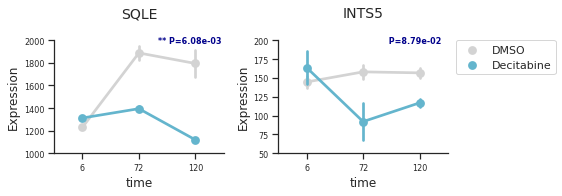

In [201]:
f, axes = plt.subplots(1, 2,figsize=(8,3))

plot_time_rna_seq(exp_counts,gene = 'SQLE',ax=axes[0],data='Expression',plot='pointplot')
axes[0].get_legend().remove()
axes[0].set_ylim(bottom=1000,top=2000)
# axes[0].set_yscale('log')

plot_time_rna_seq(exp_counts,gene = 'INTS5',ax=axes[1],data='Expression',plot='pointplot')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_ylim(bottom=50,top=200)

plt.tight_layout()
plt.savefig('Target-genes/Exp.pdf')

#### Down, 120h | GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS

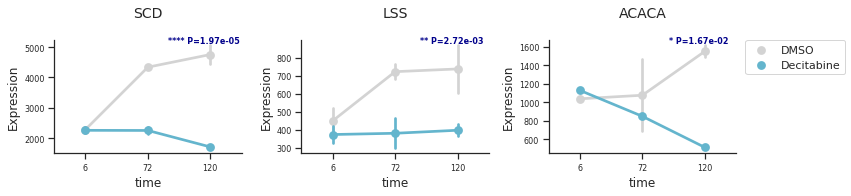

In [202]:
f, axes = plt.subplots(1, 3,figsize=(12,3))

plot_time_rna_seq(exp_counts,gene = 'SCD',ax=axes[0],data='Expression',plot='pointplot')
axes[0].get_legend().remove()
# axes[0].set_ylim(bottom=1000,top=2000)
# axes[0].set_yscale('log')

plot_time_rna_seq(exp_counts,gene = 'LSS',ax=axes[1],data='Expression',plot='pointplot')
axes[1].get_legend().remove()
# axes[1].set_ylim(bottom=50,top=200)

plot_time_rna_seq(exp_counts,gene = 'ACACA',ax=axes[2],data='Expression',plot='pointplot')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes[2].set_ylim(bottom=50,top=200)

plt.tight_layout()
# plt.savefig('Target-genes/Exp.pdf')

> #### SCD, stearoyl CoA desaturase
> [__Metabolic adaptation of acute lymphoblastic leukemia to the central nervous system microenvironment is dependent on Stearoyl CoA desaturase__](https://pubmed.ncbi.nlm.nih.gov/33479702/)
> - _We identified a metabolic signature of fatty-acid synthesis in CNS leukemia, highlighting Stearoyl-CoA desaturase (SCD1) as a key player. In vivo SCD1 overexpression increases CNS disease, whilst genetic or pharmacological inhibition of SCD1 decreases CNS load._

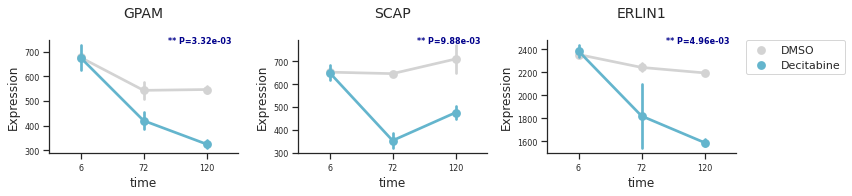

In [203]:
# gs = 'GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS'
# ['CYP51A1', 'FDFT1', 'SQLE', 'ERLIN1', 'KPNB1', 
# 'SC5D', 'HMGCR', 'SCAP', 'GPAM', 

f, axes = plt.subplots(1, 3,figsize=(12,3))

plot_time_rna_seq(exp_counts,gene = 'GPAM',ax=axes[0],data='Expression',plot='pointplot')
axes[0].get_legend().remove()
# axes[0].set_ylim(bottom=1000,top=2000)
# axes[0].set_yscale('log')

plot_time_rna_seq(exp_counts,gene = 'SCAP',ax=axes[1],data='Expression',plot='pointplot')
axes[1].get_legend().remove()
# axes[1].set_ylim(bottom=50,top=200)

plot_time_rna_seq(exp_counts,gene = 'ERLIN1',ax=axes[2],data='Expression',plot='pointplot')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes[2].set_ylim(bottom=50,top=200)

plt.tight_layout()
# plt.savefig('Target-genes/Exp.pdf')

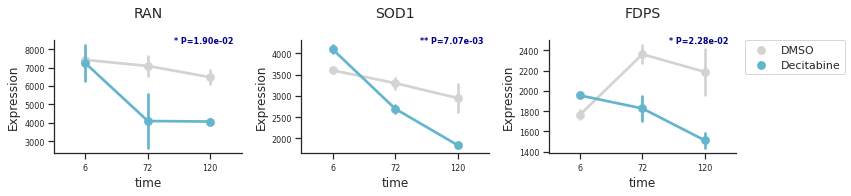

In [204]:
# 'RAN', 'SOD1', 'FDPS', 'PMVK', 'DHCR7']]

f, axes = plt.subplots(1, 3,figsize=(12,3))

plot_time_rna_seq(exp_counts,gene = 'RAN',ax=axes[0],data='Expression',plot='pointplot')
axes[0].get_legend().remove()
# axes[0].set_ylim(bottom=1000,top=2000)
# axes[0].set_yscale('log')

plot_time_rna_seq(exp_counts,gene = 'SOD1',ax=axes[1],data='Expression',plot='pointplot')
axes[1].get_legend().remove()
# axes[1].set_ylim(bottom=50,top=200)

plot_time_rna_seq(exp_counts,gene = 'FDPS',ax=axes[2],data='Expression',plot='pointplot')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes[2].set_ylim(bottom=50,top=200)

plt.tight_layout()
# plt.savefig('Target-genes/Exp.pdf')

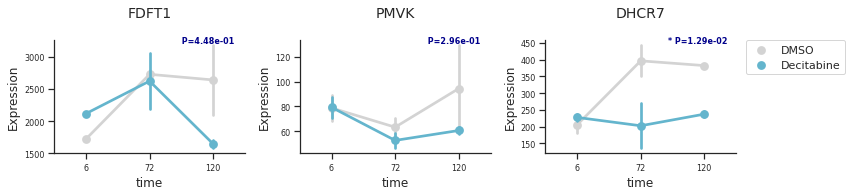

In [205]:
# 'RAN', 'SOD1', 'FDPS', 'PMVK', 'DHCR7']]

f, axes = plt.subplots(1, 3,figsize=(12,3))

plot_time_rna_seq(exp_counts,gene = 'FDFT1',ax=axes[0],data='Expression',plot='pointplot')
axes[0].get_legend().remove()
# axes[0].set_ylim(bottom=1000,top=2000)
# axes[0].set_yscale('log')

plot_time_rna_seq(exp_counts,gene = 'PMVK',ax=axes[1],data='Expression',plot='pointplot')
axes[1].get_legend().remove()

plot_time_rna_seq(exp_counts,gene = 'DHCR7',ax=axes[2],data='Expression',plot='pointplot')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes[1].set_ylim(bottom=50,top=200)

plt.tight_layout()
# plt.savefig('Target-genes/Exp.pdf')

### Stability

In [152]:
stbl_counts_norm = pd.read_csv('RNA-seq/stbl/normalized_stbl_count_table.txt',sep='\t')
stbl_counts = pd.read_csv('RNA-seq/stbl/REMBRANDTS.txt',sep='\t').set_index('GeneID').loc[stbl_counts_norm.index,]
stbl_counts['name'] = stbl_counts_norm['name']
# stbl_counts.set_index('name',inplace=True)

#### up in 6h, GOBP_REGULATION_OF_CHOLESTEROL_BIOSYNTHETIC_PROCESS
- 'NFYA', 'SQLE', 'FDPS', 'SREBF1', 'FDFT1', 'SCAP', 'PRKAA1', 'ERLIN2', 'FASN', 'SREBF2'

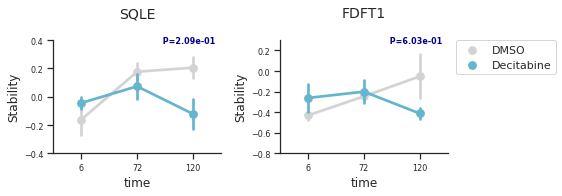

In [210]:
f, axes = plt.subplots(1, 2,figsize=(8,3))

plot_time_rna_seq(stbl_counts,gene = 'SQLE',ax=axes[0],data='Stability',plot='pointplot',ylim=ylim)
axes[0].get_legend().remove()
axes[0].set_ylim(bottom=-0.4,top=0.4)

plot_time_rna_seq(stbl_counts,gene = 'FDFT1',ax=axes[1],data='Stability',plot='pointplot',ylim=ylim)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[1].set_ylim(bottom=-0.8,top=0.3)

plt.tight_layout()
plt.savefig('Target-genes/Stbl.pdf')

#### up in 120h, GOBP_RESPONSE_TO_STEROL
- 'TGFBR2', 'GRAMD1B', 'TGFBR1', 'LRP8', 'SMAD2', 'CES1'

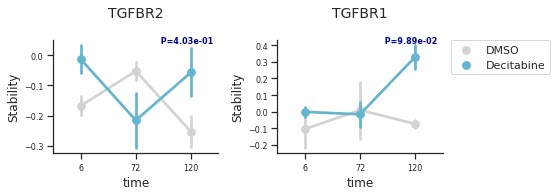

In [209]:
# TGFBR2', 'GRAMD1B', 'TGFBR1', 'LRP8', 'SMAD2', 'CES1'
f, axes = plt.subplots(1, 2,figsize=(8,3))

plot_time_rna_seq(stbl_counts,gene = 'TGFBR2',ax=axes[0],data='Stability',plot='pointplot',ylim=ylim)
axes[0].get_legend().remove()
# axes[0].set_ylim(bottom=-0.4,top=0.4)

plot_time_rna_seq(stbl_counts,gene = 'TGFBR1',ax=axes[1],data='Stability',plot='pointplot',ylim=ylim)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# axes[1].set_ylim(bottom=-0.8,top=0.3)

plt.tight_layout()

> #### FDFT1
> [__Azacitidine in combination with chemotherapy in pediatric AML patients– a phase I study__](https://aml-hub.com/medical-information/azacitidine-in-combination-with-chemotherapy-in-pediatric-aml-patients-a-phase-i-study)
> - _FDFT1 was significantly different between responders and non-responders, P = 0.002_

# meRIP-seq


> ### $\frac{IP}{Input} (drug)$ vs. $\frac{IP}{Input} (control)$

In [569]:
radar_res = pd.read_csv('meRIP-seq/hl60_delta_mtyl_table.txt',sep='\t').set_index('ensembl')

In [575]:
radar_res[radar_res.name.isin(['SQLE','INTS5'])]

,chr,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,logFC,p_value
ensembl,,,,,,,,,,,,,,
ENSG00000104549.12,chr8,124999289,124999338,SQLE,0,+,124999289,124999338,0,1,49,0,1.113278,0.000235
ENSG00000185085.2,chr11,62647794,62647843,INTS5,0,-,62647794,62647843,0,1,49,0,1.057699,0.000609
ENSG00000185085.2,chr11,62649635,62649684,INTS5,0,-,62649635,62649684,0,1,49,0,3.295837,0.000383


In [615]:
sqle_id  = 'ENSG00000104549.12'
ints5_id = 'ENSG00000185085.2'

In [616]:
IN_cnt = pd.read_csv('meRIP-seq/radar/normalized_Input_counts.txt',sep='\t')
IP_cnt = pd.read_csv('meRIP-seq/radar/normalized_IP_counts.txt',sep='\t')
ol = set(IP_cnt.index).intersection(set(IN_cnt.index))

sqle_IN_cnt = IN_cnt.loc[[o for o in ol if o.split(',')[0] == sqle_id],:]
sqle_IP_cnt = IP_cnt.loc[[o for o in ol if o.split(',')[0] == sqle_id],:]

ints5_IN_cnt = IN_cnt.loc[[o for o in ol if o.split(',')[0] == ints5_id],:]
ints5_IP_cnt = IP_cnt.loc[[o for o in ol if o.split(',')[0] == ints5_id],:]

In [784]:
def plot_meRIP_count(in_cnt,ip_cnt,title,ax,ylim=None):
    df = pd.DataFrame({
        'Input': in_cnt.mean(),
        'IP': ip_cnt.mean()
    })

    data_title = 'Normalized count'

    df['treatment'] = ["DMSO","DMSO","Decitabine","Decitabine"]
    dd=pd.melt(
        df,
        id_vars='treatment',
        var_name='meRIP'
    ).rename({'value':data_title},axis=1)

    my_pal = {"Decitabine": "c", "DMSO": "lightgray"}

    cleanAxes(ax)
    p = sns.barplot(x='meRIP',y=data_title,data=dd,hue='treatment',palette=my_pal,ax=ax,errwidth=0.4,capsize=.2)

    ax.set_title(title,y=1.1,fontsize=11)
    ax.set_xlabel(None)
    ax.set_ylim(top=ylim)

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

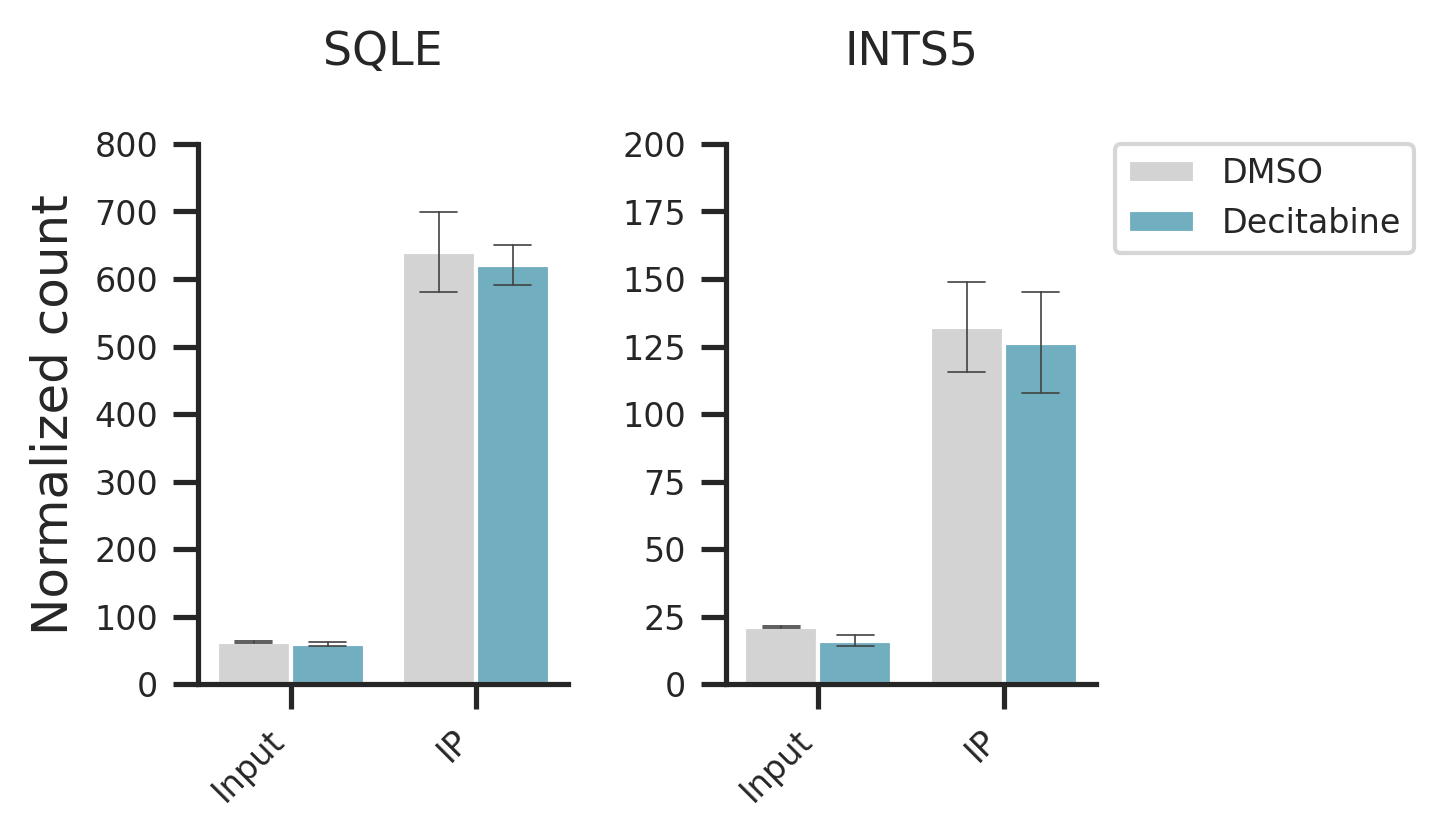

In [791]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(5,3),dpi=300)
ylim=None

plot_meRIP_count(sqle_IN_cnt,sqle_IP_cnt,
                 'SQLE',ax1,ylim=800)
plot_meRIP_count(ints5_IN_cnt,ints5_IP_cnt,
                 'INTS5',ax2,ylim=200)

ax1.get_legend().remove()
ax2.get_legend().remove()


# cleanAxes(ax2,left=False)
ax2.set_ylabel(None)
# ax2.tick_params(axis='y',label1On=False)
ax2.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 8})

f.tight_layout()
f.savefig('Target-genes/meRIP_counts.pdf')

In [303]:
!date

Tue Feb  8 19:47:24 PST 2022
